# TE 360 Final Project - Divvy Dataset Exploration

This notebook serves as the main analysis tool in exploring the Divvy bike data from January 2015 to December 2019. Inspiration for the project came from my love of biking and occasional usage of the Divvy ride-sharing system. This exploration is also the first time I've used the pandas library completely on my own for data analysis.

Prerequisites:
1. Download the Quarterly/monthly datasets from 2015 to 2019 from https://divvybikes.com/system-data
2. Place them in a folder named 'datasets' in your main directory (code will parse/clean them)
3. `pip3 install -r requirements.txt`


## Import essential libraries and dataset

The CSVs have a varied format. Some are from quarters (e.g. Q1, Q2) and some from individual months. They all follow roughly the same format though, so we'll read the CSVs, put them into a list, then concat them together to form our complete pandas dataframe.


In [59]:
# Base Python
import os
import typing

import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose

register_matplotlib_converters()


In [89]:
divvy_dfs: list[pd.DataFrame] = []
for f in os.listdir(os.getcwd() + "/datasets"):
    divvy_dfs.append(pd.read_csv(os.getcwd() + f"/datasets/{f}"))

In [61]:
divvy_complete_df: pd.DataFrame = pd.concat(divvy_dfs, ignore_index=True, sort=False)
divvy_complete_df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,01 - Rental Details Local End Time,01 - Rental Details Bike ID,01 - Rental Details Duration In Seconds Uncapped,03 - Rental Start Station ID,03 - Rental Start Station Name,02 - Rental End Station ID,02 - Rental End Station Name,User Type,Member Gender,05 - Member Details Member Birthday Year
0,4738454.0,3/31/2015 23:58,4/1/2015 0:03,1095.0,299,117.0,Wilton Ave & Belmont Ave,300.0,Broadway & Barry Ave,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4738450.0,3/31/2015 23:59,4/1/2015 0:15,537.0,940,43.0,Michigan Ave & Washington St,85.0,Michigan Ave & Oak St,Customer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4738449.0,3/31/2015 23:59,4/1/2015 0:11,2350.0,751,162.0,Damen Ave & Wellington Ave,67.0,Sheffield Ave & Fullerton Ave,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4738448.0,3/31/2015 23:59,4/1/2015 0:19,938.0,1240,51.0,Clark St & Randolph St,59.0,Wabash Ave & Roosevelt Rd,Customer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4738445.0,3/31/2015 23:54,4/1/2015 0:15,379.0,1292,134.0,Peoria St & Jackson Blvd,216.0,California Ave & Division St,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
divvy_complete_df.columns

Index(['trip_id', 'starttime', 'stoptime', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear', 'start_time',
       'end_time', '01 - Rental Details Rental ID',
       '01 - Rental Details Local Start Time',
       '01 - Rental Details Local End Time', '01 - Rental Details Bike ID',
       '01 - Rental Details Duration In Seconds Uncapped',
       '03 - Rental Start Station ID', '03 - Rental Start Station Name',
       '02 - Rental End Station ID', '02 - Rental End Station Name',
       'User Type', 'Member Gender',
       '05 - Member Details Member Birthday Year'],
      dtype='object')

## Fix/Clean Data

Despite having the complete dataframe, there are redundant columns we need to clean-up. For example, the columns '05 - Member Details Member Birthday Year' and 'birthyear' can be merged since they refer to the same type of data. This name mismatch is due to different naming conventions in different CSVs.


In [62]:
divvy_cleaned_df: pd.DataFrame = divvy_complete_df.copy(deep=True)

In [63]:
column_mapping: typing.Dict[str, str] = {
    "trip_id": "01 - Rental Details Rental ID",
    "bikeid": "01 - Rental Details Bike ID",
    "tripduration": "01 - Rental Details Duration In Seconds Uncapped",
    "from_station_id": "03 - Rental Start Station ID",
    "from_station_name": "03 - Rental Start Station Name",
    "to_station_id": "02 - Rental End Station ID",
    "to_station_name": "02 - Rental End Station Name",
    "usertype": "User Type",
    "gender": "Member Gender",
    "birthyear": "05 - Member Details Member Birthday Year",
    "start_time": "01 - Rental Details Local Start Time",
    "end_time": "01 - Rental Details Local End Time",
    "starttime": "start_time",
    "stoptime": "end_time",
}

for key, val in column_mapping.items():
    divvy_cleaned_df[key] = divvy_cleaned_df[key].fillna(divvy_cleaned_df[val])


In [64]:
divvy_cleaned_df = divvy_cleaned_df.drop(columns=column_mapping.values())

Just to be 100% sure, we display the null count by row to make sure we're not missing any values. It's okay to have some missing values in birthyear/gender since they are only available for subscribers. 

In [65]:
divvy_cleaned_df.isnull().sum(0)

trip_id                    0
starttime                  0
stoptime                   0
bikeid                     0
tripduration               0
from_station_id            0
from_station_name          0
to_station_id              0
to_station_name            0
usertype                   0
gender               3746938
birthyear            3718698
dtype: int64

In [66]:
divvy_cleaned_df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,4738454.0,3/31/2015 23:58,4/1/2015 0:03,1095.0,299,117.0,Wilton Ave & Belmont Ave,300.0,Broadway & Barry Ave,Subscriber,Male,1994.0
1,4738450.0,3/31/2015 23:59,4/1/2015 0:15,537.0,940,43.0,Michigan Ave & Washington St,85.0,Michigan Ave & Oak St,Customer,NaN,NaN
2,4738449.0,3/31/2015 23:59,4/1/2015 0:11,2350.0,751,162.0,Damen Ave & Wellington Ave,67.0,Sheffield Ave & Fullerton Ave,Subscriber,Male,1992.0
3,4738448.0,3/31/2015 23:59,4/1/2015 0:19,938.0,1240,51.0,Clark St & Randolph St,59.0,Wabash Ave & Roosevelt Rd,Customer,NaN,NaN
4,4738445.0,3/31/2015 23:54,4/1/2015 0:15,379.0,1292,134.0,Peoria St & Jackson Blvd,216.0,California Ave & Division St,Subscriber,Male,1976.0


## Preliminary Analysis

We're going to explore the dataset first before investigating our main hypotheses. There are some "mini" hypotheses that can be answered first:

1) There will be an even number of male/female divvy riders. I can't see any apparent reason why it would be skewed one way or another.

2) There will be more trips by subscribed members than non-subscribed members. Even though there are probably less subscribed members, each subscribed member will go on a lot more trips.
   
3) The mode birthyear will be around 1994. This is because in 2015, a birthyear of 1995 is around 21 years and in 2019 is would be 25 years old. I predict the average rider will be early 20s.

4) The mode trip duration will be around 10 minutes. I think this because it's enough time to get places without being too expensive.

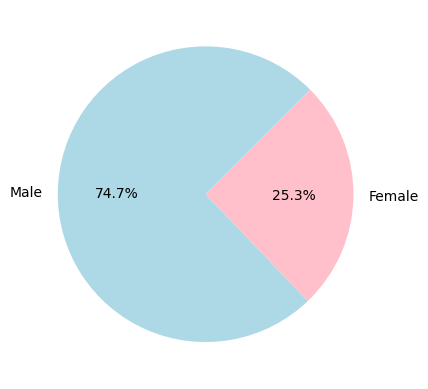

In [67]:
gender_count: pd.Series = divvy_cleaned_df['gender'].value_counts()
plt.pie(gender_count.values, labels=gender_count.index, startangle=45, colors=['lightblue', 'pink'], autopct='%1.1f%%')
plt.show()

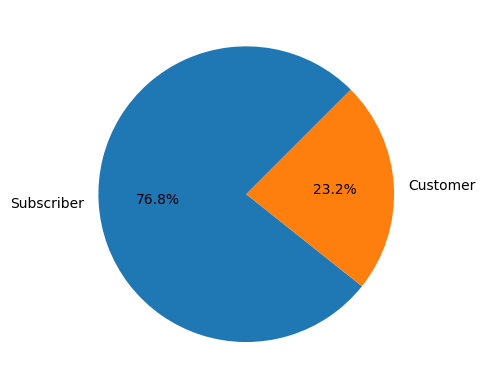

In [68]:
user_type_count: pd.Series = divvy_cleaned_df['usertype'].value_counts()
plt.pie(user_type_count.values[:2], labels=user_type_count.index[:2], startangle=45, autopct='%1.1f%%')
plt.show()

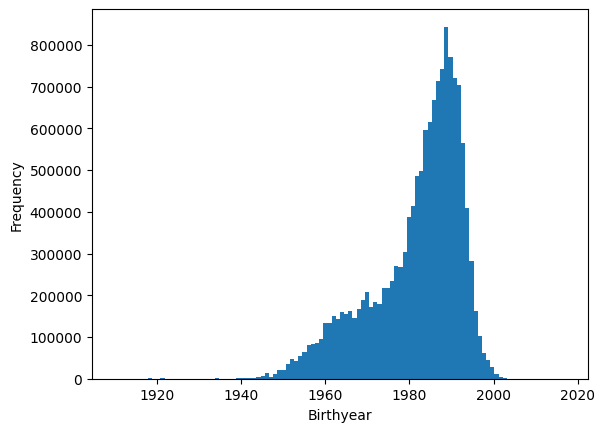

In [69]:
birthyears_cleaned: pd.Series = divvy_cleaned_df['birthyear'].dropna().loc[lambda x: x >= 1910] # Filter out anyone born before 1900 because they're dead
birthyears_cleaned.reset_index(drop=True)

plt.hist(birthyears_cleaned, bins=108)
plt.xlabel("Birthyear")
plt.ylabel("Frequency")
plt.show()

In [70]:
print(f"Mode birthyear: {(birthyears_cleaned.mode()).values[0]}")
print(f"Mean birthyear: {(birthyears_cleaned.mean())}")
print(f"Median birthyear: {(birthyears_cleaned.mean())}")

Mode birthyear: 1989.0
Mean birthyear: 1981.902806221423
Median birthyear: 1981.902806221423


In [74]:
trip_duration_cleaned: pd.Series = divvy_cleaned_df['tripduration'].dropna().apply(lambda x: int(float(x.replace(',', ''))) if (not isinstance(x, int) and not isinstance(x, float)) else x)

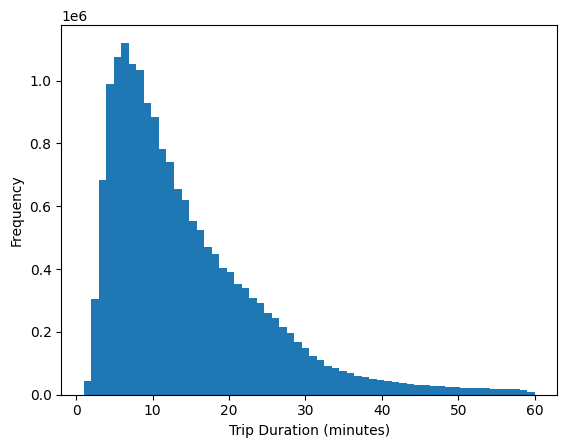

In [75]:
# Plot trip time on a histogram for trips under an hour
trip_duration_under_one_hour: pd.Series = trip_duration_cleaned.loc[lambda x: x < 60 * 60].apply(lambda x: round(x / 60)) # Histogram screwed up if we don't filter extremely high values
trip_duration_under_one_hour.reset_index(drop=True)
plt.hist(trip_duration_under_one_hour, bins=60)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

In [73]:
print(f"Mode minutes: {(trip_duration_cleaned.mode() / 60).values[0]}")
print(f"Mean minutes: {(trip_duration_cleaned.mean() / 60)}")
print(f"Median minutes: {(trip_duration_cleaned.mean() / 60)}")

Mode minutes: 5.316666666666666
Mean minutes: 19.52341163270882
Median minutes: 19.52341163270882


We can now answer our questions from above:

1) There were more trips taken by male riders than female. This is suprising.
2) The second result was not suprising. There were more rides taken by subscribers than non-subscribers. This aligns with the initial prediction.
3) The most popular birthyear is 1989. This is slightly older than I predicted. This motivates further analysis to see the mode age. Also, mean and median were high. 
4) The mode trip duration is around 5 minutes. This is a lot lower than I expected. The mean and median were a lot higher than I expected. This could be because there is significant data for longer rides, despite not being as frequent as the median. Notice the similarity with a Geometric distribution (which makes sense intuitively).

## Main Hypotheses

There are two driving questions I want to answer, along with my initial hypotheses:

1) Are there more Divvy trips over the summer? I'd hypothesize yes since it's warmer out and me personally would go on more bike trips.
2) What's the mode age of riders? I'd guess around 24-25 based on what we got up above.

### Summer Riding

The first order of business is to determine which months correspond to the summer. We'll go with what the first Google search says. Next, we'll turn the trip start date into a month. The trips are (for a vast majority) short enough that it doesn't matter using start or end time to decide the month. Then, we put them in a bar graph and analyze the results. I'll also group the trips by month and plot it on a time series to better visualize seasonality and trend.

In [77]:
start_time: pd.Series = pd.to_datetime(divvy_cleaned_df['starttime'], infer_datetime_format=True)
start_time.head()

0   2015-03-31 23:58:00
1   2015-03-31 23:59:00
2   2015-03-31 23:59:00
3   2015-03-31 23:59:00
4   2015-03-31 23:54:00
Name: starttime, dtype: datetime64[ns]

In [78]:
# Dec-Feb Winter, March-May Spring, June-August Summer, September-November Fall
def get_season(date):
    month = date.month
    if month >= 3 and month < 6:
        return "Spring"
    elif month >= 6 and month < 9:
        return "Summer"
    elif month >= 9 and month < 11:
        return "Fall"
    else:
        return "Winter"

In [79]:
months: pd.Series = start_time.apply(get_season)

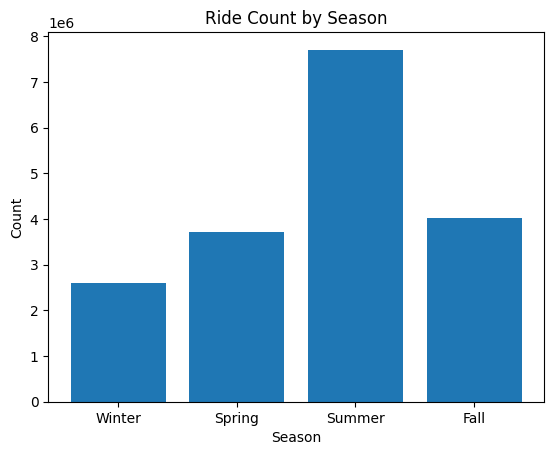

In [82]:
xaxis: list[str] = ["Winter", "Spring", "Summer", "Fall"]
yaxis: list[int] = [(months == "Winter").sum(), (months == "Spring").sum(), (months == "Summer").sum(), (months == "Fall").sum()]

plt.bar(xaxis, yaxis)
plt.title("Ride Count by Season")
plt.xlabel("Season")
plt.ylabel("Count")
plt.show()

<AxesSubplot: xlabel='starttime'>

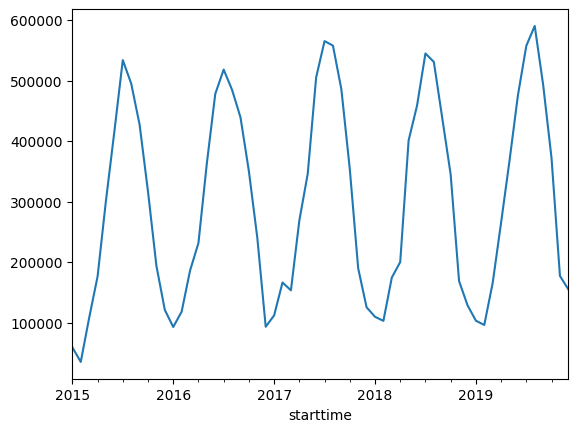

In [83]:
months.index = start_time # Reassign index to start_time to avoid creating new dataframe (don't actually use months values since we resample immediately)
start_date_by_month: pd.Series = months.resample("M").count()
start_date_by_month.plot()

Just for fun, I'd like to also plot the seasonality, trend, etc. This also could give us some more insight into our data.

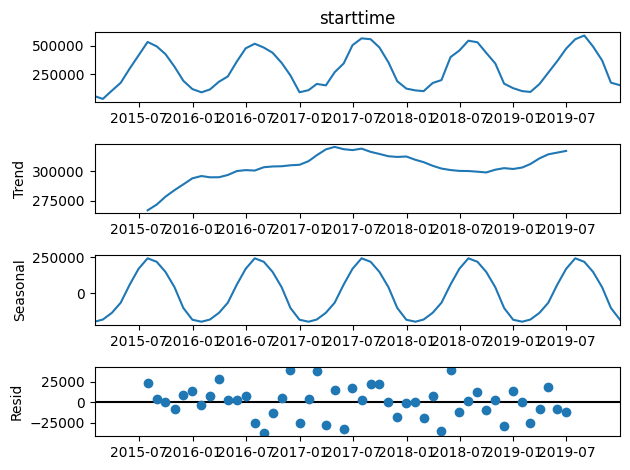

In [84]:
result = seasonal_decompose(start_date_by_month)
fig = result.plot()

### Mode Age of Riders

Now, we want to create a new pandas series that encapsulates the age of the rider, not the birthyear. To do this, we are going to take the start date year and subtract the birthyear of the rider. This should give us an approximate distribution of ages since there are so many values in the dataset.

In [85]:
datetime_and_birthyear_df: pd.DataFrame = pd.concat([start_time, divvy_cleaned_df['birthyear']], axis=1)
datetime_and_birthyear_cleaned_df: pd.DataFrame = datetime_and_birthyear_df.dropna().reset_index(drop=True)

datetime_and_birthyear_cleaned_df.head()

,starttime,birthyear
0,2015-03-31 23:58:00,1994.0
1,2015-03-31 23:59:00,1992.0
2,2015-03-31 23:54:00,1976.0
3,2015-03-31 23:53:00,1992.0
4,2015-03-31 23:49:00,1989.0


In [86]:
rider_age: pd.Series = datetime_and_birthyear_cleaned_df.apply(lambda row: row['starttime'].year - row['birthyear'], axis=1)
rider_age.head()

0    21.0
1    23.0
2    39.0
3    23.0
4    26.0
dtype: float64

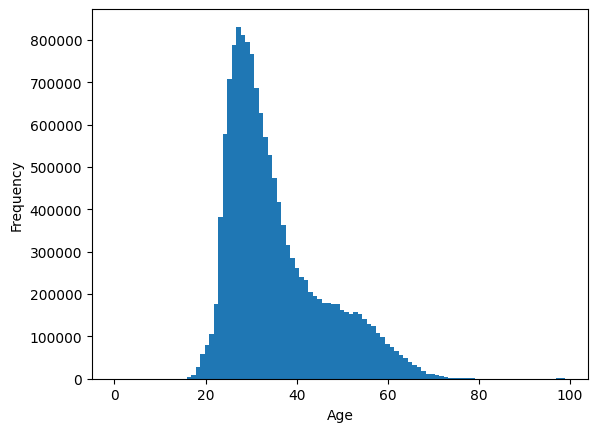

In [87]:
rider_age: pd.Series = rider_age.loc[lambda age: age < 100] # Filter out anyone above 100 because they probably can't ride a bike
plt.hist(rider_age, bins=100)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [88]:
print(f"Mode age: {rider_age.mode().values[0]}")
print(f"Mean age: {rider_age.mean()}")
print(f"Median age: {rider_age.median()}")

Mode age: 27.0
Mean age: 35.258768351895064
Median age: 32.0


## Results

The results for number of rides by season was not suprising. The summer had by far the greatest number with the least number taken over the winter. Also, the number of rides for fall/spring were approximately the same. Looking at the time-series further shows the inherent seasonality of Divvy bike rentals. It oscillates pretty regularly every year. It's also interesting to notice the upward trend until 2018 when it took a small dip. This was before the COVID-19 epidemic, so I wonder what the cause was. Maybe further analysis on data from 2020 onwards would help.

The results for the mean/median/mode of rider age were higher than I expected. I didn't predict that either the mean/median would be above 30. This shows that Divvy is not only popular with younger people. This is somewhat suprising because I'd expect younger people to like biking more and for older people to get around by car/bus/train more often.

## Further Research

This notebook only scratches the surface of what can be analyzed. One idea I planned on undertaking was comparing Divvy ride data to CTA train data to compare their respective seasonalities. We saw that rides increased over the summer, so does that mean less people are riding CTA? This is an interesting question left unanswered (for now).

I also wanted to produce a graph visualization of the dataset, perhaps overlayed on a geographical map. That is outside the scope of the project, but would be fun to explore at a later date.



Then there's the obvious inclusion of more recent data, however the format of it is slightly different than that above. Also, it introduces slower processing time. A way to approach this would be to develop models that work on the data from 2015-2019, figure out how to format 2020-2023 in a compatible way, then wait and analyze all at once.

To be continued...